In [4]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import pipeline
import joblib

np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [20]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

In [21]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [22]:
data.drop('id', axis=1, inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [24]:
data.duplicated().any()

np.False_

In [25]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [26]:
data.bmi.fillna(data.bmi.mean(), inplace=True)

In [27]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [28]:
numerical = data.select_dtypes(include=["int64","float64"]).columns.to_list()
numerical

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [29]:
data[numerical[:1]] = StandardScaler().fit_transform(data[numerical[:1]])

In [30]:
categories = data.select_dtypes(include=['object']).columns.tolist()
categories

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [31]:
data.drop(data[data.gender == 'Other'].index,inplace=True)
data.reset_index(drop=True,inplace=True)

In [32]:
data.gender = data.gender.map({'Male':0,'Female':1})

In [33]:
data.ever_married = data.ever_married.map({'No':0,'Yes':1})

In [34]:
data.work_type = data.work_type.map({'Private':0,'Self-employed':1,'children':2,'Govt_job':3,'Never_worked':4})

In [35]:
data.Residence_type = data.Residence_type.map({'Urban':0,'Rural':1})

In [36]:
data.smoking_status = data.smoking_status.map({'never smoked':0,'formerly smoked':1,'smokes':2,'Unknown':3})

In [37]:
X = data.drop('stroke',axis=1)
y = data.stroke
X.shape,y.shape

((5109, 10), (5109,))

In [38]:
y.value_counts()

stroke
0    4860
1     249
Name: count, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 100]
}
# Inisialisasi base learners
rf_model = RandomForestClassifier(random_state=1234)  # Random Forest
svm_model = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=1234),
    param_distributions=parameters,
    cv=5,
    random_state=1234
)

In [6]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('random_forest', rf_model),
        ('svm', svm_model)
    ],
    voting='soft'  # Soft voting menggunakan probabilitas untuk memutuskan kelas
)

Accuracy: 0.9501
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



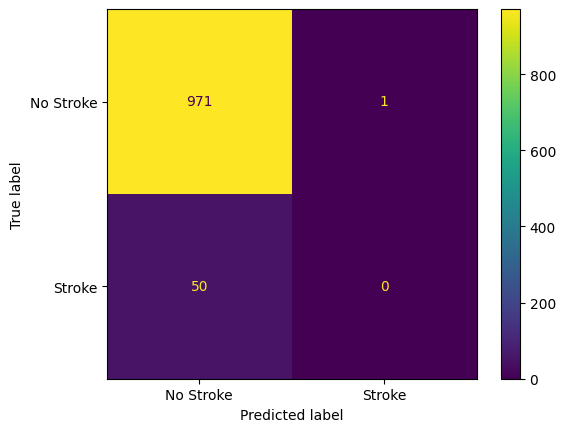

In [43]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

# Latih ensemble model
ensemble_model.fit(X_train, y_train)

# Prediksi label
y_pred = ensemble_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['No Stroke', 'Stroke']).plot()
plt.show()

In [7]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
data.drop('id', axis=1, inplace=True)
dataArray = data.values
data.drop('stroke', axis=1, inplace=True)
numerical = data.select_dtypes(include=["int64","float64"]).columns.to_list()
categories = data.select_dtypes(include=['object']).columns.tolist()
numerical_indices = [data.columns.get_loc(col) for col in numerical]
categorical_indices = [data.columns.get_loc(col) for col in categories]
x = dataArray[:,:-1]
y = dataArray[:,-1]
y = y.astype(int)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority')
x, y = ros.fit_resample(x, y)

numeric_transformer = pipeline.Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_indices),
    ('cat', categorical_transformer, categorical_indices)
])
x = preprocessor.fit_transform(x)
joblib.dump(preprocessor, open('../artifacts/embedding.joblib', "wb"))

p = pipeline.Pipeline([
    ('Scaler', StandardScaler())
])
x = p.fit_transform(x)
joblib.dump(p, open('../artifacts/scaler.joblib', "wb"))

p = pipeline.Pipeline([
        ('Classifier', ensemble_model)
    ])

p.fit(x,y)

joblib.dump(p, open('../artifacts/model.joblib', "wb"))

In [6]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
data.drop('id', axis=1, inplace=True)
dataArray = data.values
x = dataArray[:, :-1]
y = dataArray[:, -1]
y = y.astype(int)

joblib_embedding = joblib.load('../artifacts/embedding.joblib')
joblib_scaler = joblib.load('../artifacts/scaler.joblib')

# Apply the embedding and scaler
x_transformed = joblib_embedding.transform(x)
x_scaled = joblib_scaler.transform(x_transformed)

# Combine the processed data back into a DataFrame with the original column names
numerical = data.select_dtypes(include=["int64", "float64"]).columns.to_list()
categories = data.select_dtypes(include=['object']).columns.tolist()
processed_columns = numerical[:-1] + categories  # Exclude 'stroke' column from numerical

x = pd.DataFrame(x_scaled, columns=processed_columns)
y = pd.DataFrame(y, columns=["stroke"])
data = pd.concat([x, y], axis=1)
data.to_csv("../data/ref_data.csv", index=False)